# Cleaning Precipitation Data
Precipitation data suffers from a few issues:
* large outliers which are almost certainly erroneous (like daily precipitation >10 inches)
* temporal anomalies (annual totals show that something is wrong with 1973 data at most stations)
* fundamental data limitations: sometimes zero precipitation is simply not reported, which makes it impossible to differentiate "zero" from "missing" using only this dataset.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
from pathlib import Path
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

import src.data.loaders as load

In [11]:
# this loads a csv of manual exclusions and sets precip values to nan.
# I didn't use a statistical anomaly detector because one of the first
# outliers (40 standard deviations away!) I discovered was actually a real
# 6+ inch rain storm in Cheyenne www.weather.gov/cys/August1985CheyenneFlood
# But after manually reviewing 40 others, that turned out to be the ONLY real one 🥴

from src.analysis.precipitation import set_manual_exclusions_to_nan, _load_erroneous_precip_points, clean_precip_data

In [13]:
pd.options.display.max_columns= 50

In [14]:
gsod = load.get_gsod()

In [15]:
gsod.head(2)

,timestamp,usaf,wban,temp_f_mean,temp_count,dew_point_f_mean,dew_point_count,sea_level_pressure_mbar_mean,sea_level_pressure_count,pressure_mbar_mean,pressure_count,visbility_miles_mean,visbility_count,wind_speed_knots_mean,wind_speed_count,temp_f_max,temp_max_measurement_type,temp_f_min,temp_min_measurement_type,precipitation_total_inches,precipitation_measurement_type,snow_depth_inches,had_rain,had_snow_ice,had_hail
0,1985-01-26,691484,99999,38.099998,5,37.400002,5,NaN,0,NaN,0,4.8,5,5.2,5,39.200001,*,37.400002,*,NaN,NaN,0.8,1,0,0
1,1985-01-27,691484,99999,34.500000,5,30.600000,5,NaN,0,NaN,0,4.9,5,3.8,5,39.200001,*,30.200001,*,NaN,NaN,NaN,1,1,0


In [16]:
best_station_meta = pd.read_csv('../data/interim/stations_for_scoping_analysis.csv', dtype={'usaf': str, 'wban': str}, index_col=['usaf', 'wban'])
best_station_meta.head(2)

,,min,max,count,time_coverage,name,country,state,call,latitude,longitude,elevation_ft,nominal_begin_date,nominal_end_date,nearest_city,distance_km,nominal_duration_years
usaf,wban,,,,,,,,,,,,,,,,
723650,23050,1941-07-01,2022-04-17,28281,0.958321,ALBUQUERQUE INTL SUNPORT AIRP,US,NM,KABQ,35.042,-106.616,1618.5,1941-07-01,2021-09-21,Albuquerque,5.659381,80.224504
726770,24033,1935-05-01,2022-04-17,20143,0.634146,BILLINGS LOGAN INTERNATIONAL,US,MT,KBIL,45.807,-108.542,1091.5,1935-05-01,2021-09-21,Billings,4.148528,86.392882


In [17]:
subset_cols = ['timestamp', 'temp_f_mean', 'temp_count', 'temp_f_max', 'temp_f_min', 'precipitation_total_inches',
               'temp_max_measurement_type', 'temp_min_measurement_type', 'precipitation_measurement_type',
              ]
subset = gsod.set_index(['usaf', 'wban']).loc[best_station_meta.index, subset_cols].set_index('timestamp', append=True).sort_index()

In [18]:
subset.head(2)

temp_f_mean  temp_count  temp_f_max  temp_f_min  \
usaf   wban  timestamp                                                     
711210 99999 1944-10-10    44.000000          17   59.400002   33.400002   
             1944-10-11    49.299999          24   75.400002   33.400002   

                         precipitation_total_inches temp_max_measurement_type  \
usaf   wban  timestamp                                                          
711210 99999 1944-10-10                         0.0                         *   
             1944-10-11                         0.0                         *   

                        temp_min_measurement_type  \
usaf   wban  timestamp                              
711210 99999 1944-10-10                         *   
             1944-10-11                         *   

                        precipitation_measurement_type  
usaf   wban  timestamp                                  
711210 99999 1944-10-10                              I  
             1944-10-11                              I

In [19]:
subset.shape

(904184, 8)

In [20]:
del gsod

In [21]:
idx = pd.IndexSlice

In [22]:
exclusion_idx = _load_erroneous_precip_points()

In [23]:
set_manual_exclusions_to_nan(subset, exclusion_idx=exclusion_idx, column='precipitation_total_inches')

In [24]:
#filter_ = idx['726770','24033', :]
filter_ = idx['724930', '23230', :] # Oakland Intl
city = subset.loc[filter_, :].reset_index(level=[0,1])

In [25]:
city.head(2)

,usaf,wban,temp_f_mean,temp_count,temp_f_max,temp_f_min,precipitation_total_inches,temp_max_measurement_type,temp_min_measurement_type,precipitation_measurement_type
timestamp,,,,,,,,,,
1943-01-01,724930,23230,54.400002,16,56.299999,53.400002,NaN,*,*,NaN
1943-01-02,724930,23230,50.299999,24,56.299999,44.400002,NaN,*,*,NaN


In [26]:
city.describe()

,temp_f_mean,temp_count,temp_f_max,temp_f_min,precipitation_total_inches
count,16718.000000,16718.000000,16718.000000,16718.000000,16117.000000
mean,57.611710,23.659947,66.721100,50.938442,0.030406
std,6.152011,0.925140,8.289663,6.712046,0.147164
min,30.500000,7.000000,39.000000,24.299999,0.000000
25%,53.500000,24.000000,61.000000,46.400002,0.000000
50%,58.099998,24.000000,66.000000,52.000000,0.000000
75%,61.799999,24.000000,72.000000,55.900002,0.000000
max,82.800003,24.000000,104.000000,70.000000,3.570000


In [27]:
city['precipitation_measurement_type'].describe()

count     16118
unique        7
top           G
freq       6840
Name: precipitation_measurement_type, dtype: object

<AxesSubplot:xlabel='timestamp'>

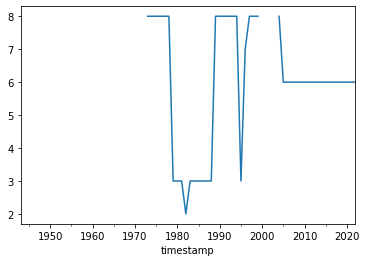

In [28]:
city['precipitation_measurement_type'].map(dict(zip(list('ABCDEFGHI'), range(9)))).resample('AS').median().plot()

In [29]:
city['precipitation_measurement_type'].value_counts(dropna=False, normalize=True)

G      0.409140
I      0.276708
D      0.182797
NaN    0.035889
H      0.033916
C      0.026857
A      0.023866
B      0.010827
Name: precipitation_measurement_type, dtype: float64

In [30]:
city.groupby('precipitation_measurement_type')['precipitation_total_inches'].mean()

precipitation_measurement_type
A    0.071482
B    0.062376
C    0.032739
D    0.003989
G    0.061904
H    0.000000
I    0.000000
Name: precipitation_total_inches, dtype: float32

In [31]:
city[city['precipitation_measurement_type'].eq('I')].head()

,usaf,wban,temp_f_mean,temp_count,temp_f_max,temp_f_min,precipitation_total_inches,temp_max_measurement_type,temp_min_measurement_type,precipitation_measurement_type
timestamp,,,,,,,,,,
1943-01-03,724930,23230,49.900002,24,58.299999,41.400002,0.0,*,*,I
1943-01-04,724930,23230,50.000000,24,58.299999,45.299999,0.0,*,*,I
1943-01-05,724930,23230,50.599998,24,55.400002,45.299999,0.0,*,*,I
1943-01-06,724930,23230,53.700001,24,66.400002,49.299999,0.0,*,*,I
1943-01-07,724930,23230,58.099998,24,67.300003,52.299999,0.0,*,*,I


<AxesSubplot:xlabel='timestamp'>

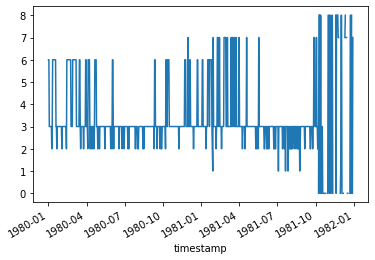

In [32]:
city.loc['1980':'1981', 'precipitation_measurement_type'].map(dict(zip(list('ABCDEFGHI'), range(9)))).plot()

In [33]:
types = city.groupby('precipitation_measurement_type').resample('AS')['precipitation_total_inches'].agg(['sum', 'mean', 'count'])

<AxesSubplot:xlabel='timestamp'>

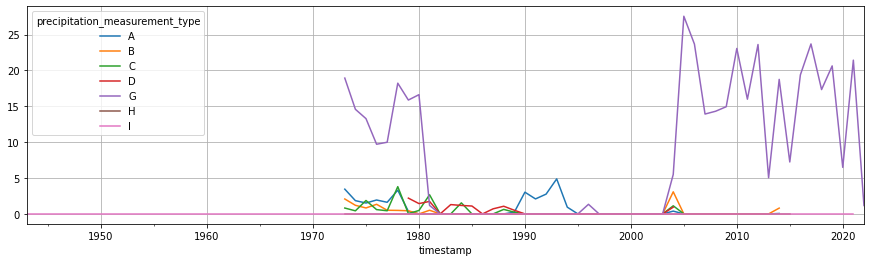

In [34]:
types['sum'].unstack(level=0).plot(figsize=(15,4), grid=True)#, ylim=(0, 0.5))

<AxesSubplot:xlabel='timestamp'>

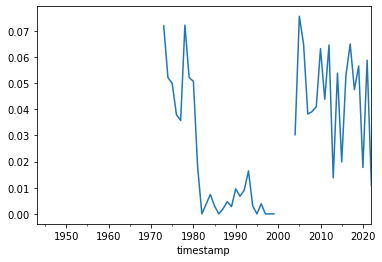

In [35]:
city['precipitation_total_inches'].resample('AS').mean().plot()

In [36]:
# The first year of data is full of garbage
city['precipitation_total_inches'].nlargest(15)

timestamp
2021-10-25    3.57
2014-12-12    3.22
1978-03-09    3.11
2021-12-14    2.81
2018-01-09    2.78
2018-04-07    2.58
1973-11-06    2.32
2009-10-14    2.32
2009-02-16    1.95
1973-12-27    1.93
2008-01-05    1.92
2021-12-24    1.85
2014-12-03    1.78
2012-04-13    1.77
2012-03-15    1.64
Name: precipitation_total_inches, dtype: float32

<AxesSubplot:>

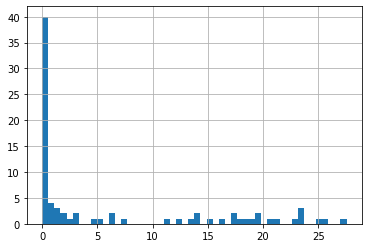

In [37]:
# lol that 1973 outlier
city['precipitation_total_inches'].resample('AS').sum().hist(bins=50)

<AxesSubplot:xlabel='timestamp'>

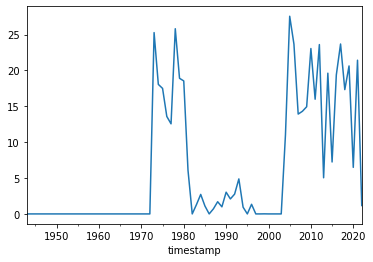

In [38]:
# lol that 1973 outlier
city['precipitation_total_inches'].resample('AS').sum().plot()

<AxesSubplot:xlabel='timestamp'>

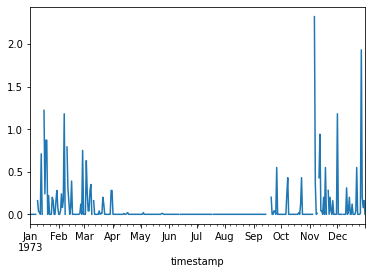

In [39]:
city.loc['1973', 'precipitation_total_inches'].plot()

<AxesSubplot:xlabel='timestamp'>

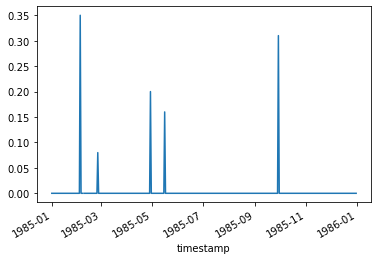

In [40]:
city.loc['1985', 'precipitation_total_inches'].plot()

In [41]:
city.loc[city.loc['1982', 'precipitation_total_inches'].idxmax(),:]

usaf                                 724930
wban                                  23230
temp_f_mean                       50.599998
temp_count                               24
temp_f_max                             55.0
temp_f_min                             45.0
precipitation_total_inches              0.0
temp_max_measurement_type                 *
temp_min_measurement_type                 *
precipitation_measurement_type            H
Name: 1982-01-01 00:00:00, dtype: object

In [42]:
# exclude garbage
city.loc['1973-06-01':,'precipitation_total_inches'].nlargest(15)

timestamp
2021-10-25    3.57
2014-12-12    3.22
1978-03-09    3.11
2021-12-14    2.81
2018-01-09    2.78
2018-04-07    2.58
1973-11-06    2.32
2009-10-14    2.32
2009-02-16    1.95
1973-12-27    1.93
2008-01-05    1.92
2021-12-24    1.85
2014-12-03    1.78
2012-04-13    1.77
2012-03-15    1.64
Name: precipitation_total_inches, dtype: float32

<AxesSubplot:>

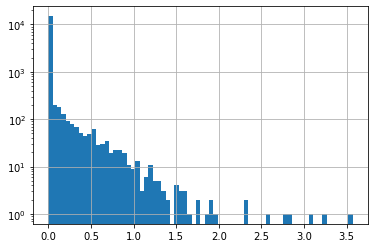

In [43]:
city['precipitation_total_inches'].hist(bins=70, log=True)

<AxesSubplot:>

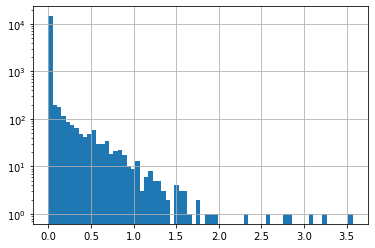

In [44]:
city.loc['1974':,'precipitation_total_inches'].hist(bins=70, log=True)

<AxesSubplot:>

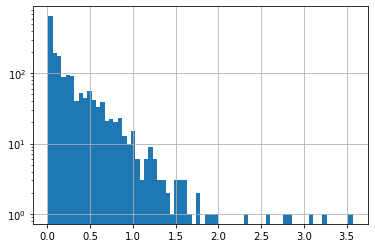

In [45]:
city.loc['1974':,'precipitation_total_inches'].replace(0, np.nan).hist(bins=70, log=True)

In [46]:
# can roughly model this as exponential distribution. Std dev = mean
city.loc['1974':,'precipitation_total_inches'].mean()

0.029718654

In [47]:
# the pile of zeros don't quite fit that distribution, so remove them
city.loc['1974':,'precipitation_total_inches'].replace(0, np.nan).mean()

0.26110676

In [48]:
city.loc[:,'precipitation_total_inches'].replace(0, np.nan).mean()

0.26318473

<AxesSubplot:>

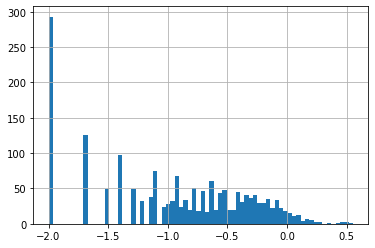

In [49]:
# limited precision ruins low end of histogram
city.loc['1974':,'precipitation_total_inches'].replace(0, np.nan).transform(np.log10).hist(bins=70)#, log=True)

In [50]:
additive_jitter = np.random.uniform(-0.005, 0.005, size=city.loc['1974':,'precipitation_total_inches'].shape[0])

<AxesSubplot:>

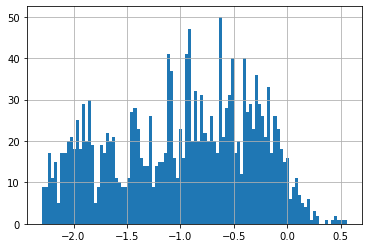

In [51]:
(city.loc['1974':,'precipitation_total_inches']
 .replace(0, np.nan)
 .add(additive_jitter)
 .transform(np.log10)
 .hist(bins=100)
)

In [52]:
scale_factor = 0.2
multiplicative_jitter = np.random.uniform(1-scale_factor, 1+scale_factor, size=city.loc['1974':,'precipitation_total_inches'].shape[0])

<AxesSubplot:>

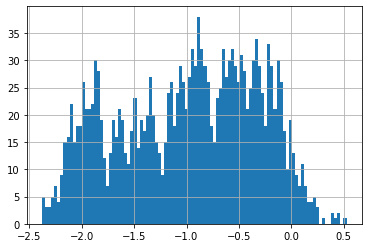

In [53]:
(city.loc['1974':,'precipitation_total_inches']
 .replace(0, np.nan)
 .mul(multiplicative_jitter)
 .add(additive_jitter)
 .transform(np.log10)
 .hist(bins=100)
)

<AxesSubplot:>

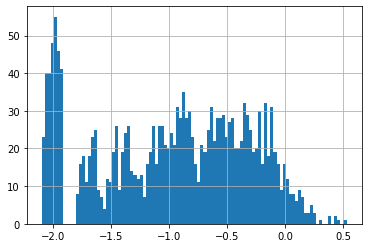

In [54]:
# multiplicative only
(city.loc['1974':,'precipitation_total_inches']
 .replace(0, np.nan)
 .mul(multiplicative_jitter)
 .transform(np.log10)
 .hist(bins=100)
)

In [55]:
city.head()

,usaf,wban,temp_f_mean,temp_count,temp_f_max,temp_f_min,precipitation_total_inches,temp_max_measurement_type,temp_min_measurement_type,precipitation_measurement_type
timestamp,,,,,,,,,,
1943-01-01,724930,23230,54.400002,16,56.299999,53.400002,NaN,*,*,NaN
1943-01-02,724930,23230,50.299999,24,56.299999,44.400002,NaN,*,*,NaN
1943-01-03,724930,23230,49.900002,24,58.299999,41.400002,0.0,*,*,I
1943-01-04,724930,23230,50.000000,24,58.299999,45.299999,0.0,*,*,I
1943-01-05,724930,23230,50.599998,24,55.400002,45.299999,0.0,*,*,I


<AxesSubplot:xlabel='timestamp'>

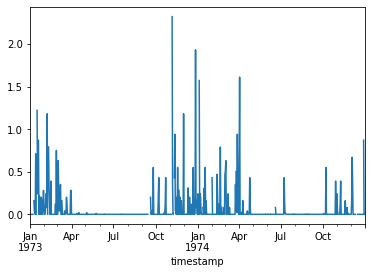

In [56]:
city.loc['1973':'1974','precipitation_total_inches'].plot()

In [57]:
#city.reset_index().to_csv('../data/interim/spokane_sample_data.csv', index=False)

## Extreme precipitation verification
For each city:
1. remove 1973 data
1. calculate mean (equal to std dev of exponential dist) of non-zero daily precipitation
1. flag values > 20 or so times the std dev
1. manually review them

In [58]:
no_1973_filter = subset.reset_index('timestamp', drop=False)['timestamp'].dt.year != 1973

In [59]:
no_1973 = subset.loc[no_1973_filter.values, ['precipitation_total_inches']].replace(0, np.nan)

In [60]:
no_1973['mean_precip'] = no_1973.groupby(level=[0,1]).transform(np.mean)

In [61]:
no_1973['z_score'] = no_1973['precipitation_total_inches'].div(no_1973['mean_precip'])

In [62]:
red_flags = no_1973.loc[no_1973['z_score'].gt(20),:].reset_index()

In [63]:
red_flags.shape

(14, 6)

In [64]:
red_flags

,usaf,wban,timestamp,precipitation_total_inches,mean_precip,z_score
0,711210,99999,1987-08-05,2.40,0.115958,20.697197
1,711210,99999,1988-07-06,3.62,0.115958,31.218269
2,711210,99999,1990-07-03,3.78,0.115958,32.598083
3,711210,99999,2018-06-12,2.52,0.115958,21.732056
4,711230,99999,1980-08-28,3.23,0.138281,23.358242
5,711230,99999,1988-07-06,2.93,0.138281,21.188745
6,711230,99999,1990-07-03,2.86,0.138281,20.682529
7,711230,99999,2001-07-29,3.67,0.138281,26.540169
8,711230,99999,2017-12-17,3.15,0.138281,22.779711
9,711230,99999,2018-01-23,3.15,0.138281,22.779711


In [65]:
flag_iter = red_flags.loc[red_flags['precipitation_total_inches'].gt(3),:].iterrows()

In [66]:
window = pd.Timedelta('366d')
window

Timedelta('366 days 00:00:00')

In [67]:
_, row = next(flag_iter)
window_slice = subset.loc[
    idx[row['usaf'], row['wban'],
        row['timestamp'] - window/2 : row['timestamp']+window/2
       ]
    , 'precipitation_total_inches']
row

usaf                                       711210
wban                                        99999
timestamp                     1988-07-06 00:00:00
precipitation_total_inches                   3.62
mean_precip                              0.115958
z_score                                 31.218269
Name: 1, dtype: object

<AxesSubplot:title={'center':'EDMONTON/NAMAO(MIL)'}, xlabel='timestamp'>

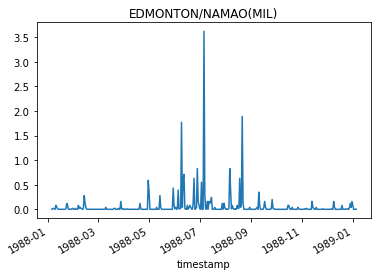

In [68]:
window_slice.reset_index(['usaf','wban'], drop=True).plot(
    title=f"{best_station_meta.at[(row['usaf'], row['wban']), 'name']}")

<AxesSubplot:>

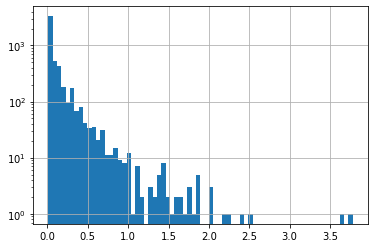

In [69]:
subset.loc[idx[row['usaf'], row['wban'], '1974':],
    'precipitation_total_inches'
].replace(0, np.nan).hist(bins=70, log=True)

In [70]:
row['usaf'], row['wban'], row['timestamp'].strftime('%Y-%m-%d')

('711210', '99999', '1988-07-06')

In [71]:
#red_flags.loc[red_flags['precipitation_total_inches'].gt(8), ['usaf', 'wban', 'timestamp']].to_csv('../data/processed/precip.csv', index=False)

## Remove 1973 garbage

In [72]:
grp = subset.loc[:, 'precipitation_total_inches'].groupby(level=[0,1])

In [73]:
def compare(df):
    seventy_three = df.loc[idx[:,:,'1973-01-01':'1973-05-31']]
    the_rest = df.loc[idx[:,:,'1974':]]
    # compare the first 5 months of each year
    the_rest = the_rest.loc[the_rest.index.get_level_values('timestamp').month <= 5]
    if len(seventy_three) < 100: # bad coverage
        return np.nan
    annual_precip = the_rest.reset_index(['usaf', 'wban'], drop=True).resample('AS').sum()
    return (seventy_three.sum() - annual_precip.mean()) / annual_precip.std()

In [74]:
comparison = grp.apply(compare)

/tmp/ipykernel_31796/896438052.py:9: RuntimeWarning: invalid value encountered in float_scalars
  return (seventy_three.sum() - annual_precip.mean()) / annual_precip.std()


<AxesSubplot:>

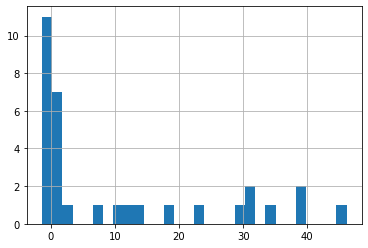

In [75]:
comparison.hist(bins=30)

In [76]:
comparison

usaf    wban 
711210  99999          NaN
711230  99999    39.655418
718770  99999          NaN
718920  99999          NaN
722740  23160    29.885149
722745  23109    -0.064121
722780  23183    13.883804
722785  23111    -0.167026
722786  23104     1.925519
722880  23152    -0.621224
722900  23188    -0.118846
722906  93112    -0.386210
722930  93107          NaN
722931  93107          NaN
722950  23174    18.642389
722970  23129     0.606436
723650  23050     0.917375
723860  23169    38.577911
724695  23036     1.402871
724880  23185    31.073006
724930  23230     1.048339
724940  23234    11.615730
725640  24018    -1.151300
725720  24127    23.345560
725755  24101     1.114595
725846  93201          NaN
        99999     0.864720
726770  24033    33.480701
726810  24131    30.576529
726930  24221     6.851582
726980  24229    -1.315666
726985  24242          NaN
        99999    -0.287591
727850  24157    46.108269
727855  24114    -0.120542
727930  24233    11.101896
727935  24234 

In [77]:
sus = comparison[(comparison > 3) & (comparison < 20)].iteritems()

<AxesSubplot:title={'center':'z-score: 13.88'}, xlabel='timestamp'>

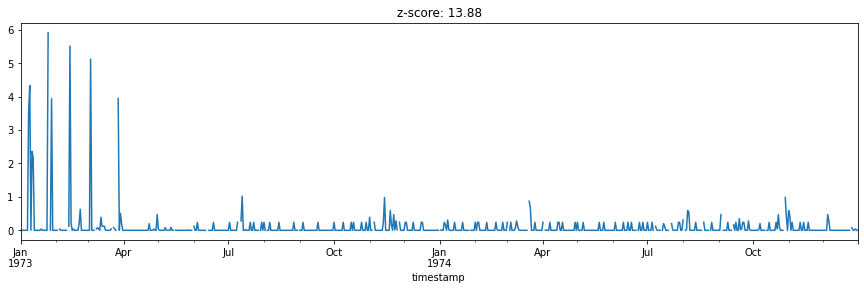

In [78]:
station, z_score = next(sus)
(subset.loc[idx[station[0], station[1], '1973':'1974'], 'precipitation_total_inches']
 .reset_index(['usaf', 'wban'], drop=True)
 .plot(figsize=(15,4), title=f"z-score: {z_score:.2f}")
)

<AxesSubplot:title={'center':'z-score: 18.64'}, xlabel='timestamp'>

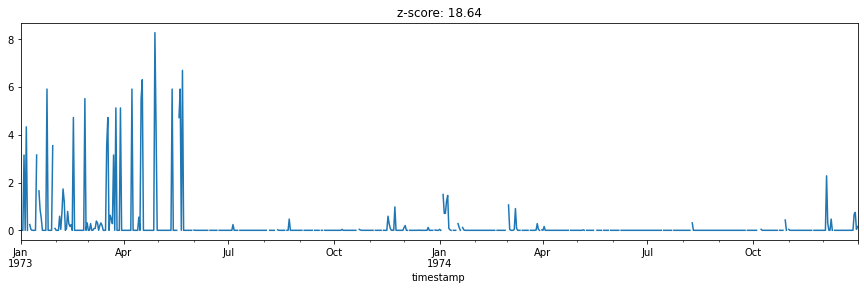

In [79]:
station, z_score = next(sus)
(subset.loc[idx[station[0], station[1], '1973':'1974'], 'precipitation_total_inches']
 .reset_index(['usaf', 'wban'], drop=True)
 .plot(figsize=(15,4), title=f"z-score: {z_score:.2f}")
)

<AxesSubplot:title={'center':'z-score: 11.62'}, xlabel='timestamp'>

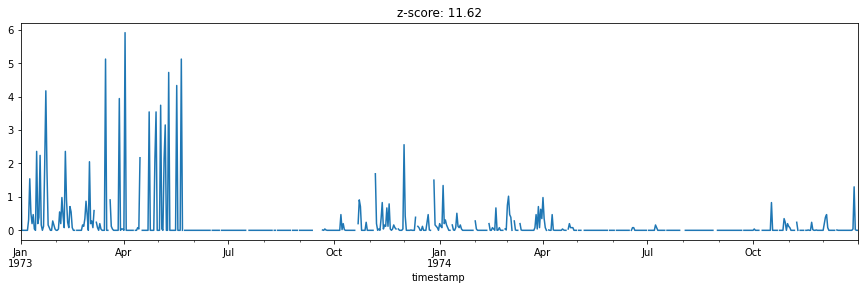

In [80]:
station, z_score = next(sus)
(subset.loc[idx[station[0], station[1], '1973':'1974'], 'precipitation_total_inches']
 .reset_index(['usaf', 'wban'], drop=True)
 .plot(figsize=(15,4), title=f"z-score: {z_score:.2f}")
)

<AxesSubplot:title={'center':'z-score: 6.85'}, xlabel='timestamp'>

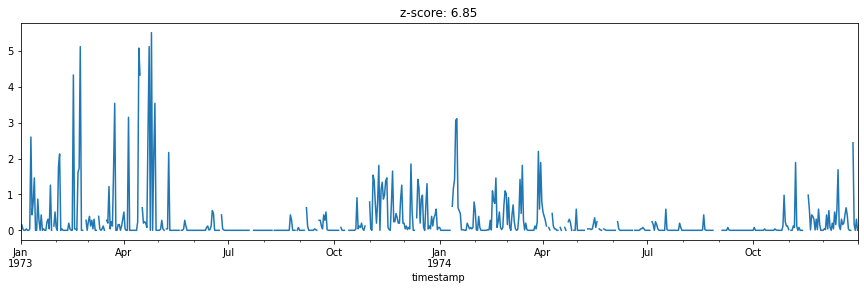

In [81]:
station, z_score = next(sus)
(subset.loc[idx[station[0], station[1], '1973':'1974'], 'precipitation_total_inches']
 .reset_index(['usaf', 'wban'], drop=True)
 .plot(figsize=(15,4), title=f"z-score: {z_score:.2f}")
)

<AxesSubplot:title={'center':'z-score: 11.10'}, xlabel='timestamp'>

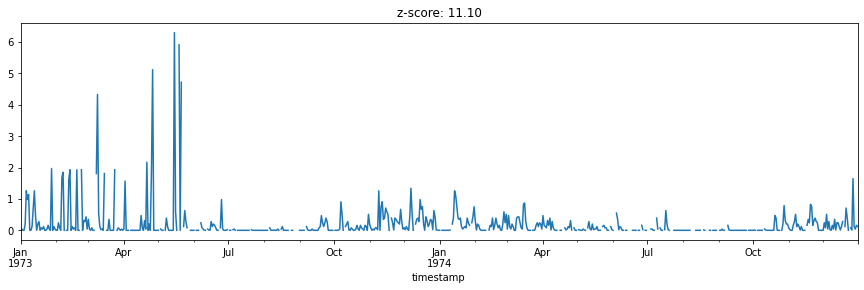

In [82]:
station, z_score = next(sus)
(subset.loc[idx[station[0], station[1], '1973':'1974'], 'precipitation_total_inches']
 .reset_index(['usaf', 'wban'], drop=True)
 .plot(figsize=(15,4), title=f"z-score: {z_score:.2f}")
)

In [83]:
station, z_score = next(sus)
(subset.loc[idx[station[0], station[1], '1973':'1974'], 'precipitation_total_inches']
 .reset_index(['usaf', 'wban'], drop=True)
 .plot(figsize=(15,4), title=f"z-score: {z_score:.2f}")
)

StopIteration: 

In [ ]:
# cut off at 5

In [150]:
clean = clean_precip_data(subset)

In [151]:
annual_precip = clean.groupby([pd.Grouper(level='usaf'),
                               pd.Grouper(level='wban'),
                               pd.Grouper(level='timestamp', freq='AS')
                              ])['precipitation_total_inches'].agg(['sum', 'count'])

In [152]:
thresh = 365 * 0.9
annual_precip.loc[:, 'sum'].where(annual_precip.loc[:,'count'].ge(thresh), inplace=True)
# remove erroneous near-zero annual totals
annual_precip.loc[:, 'sum'].where(annual_precip.loc[:,'sum'].ge(1.0), inplace=True)
annual_precip.rename(columns={'sum': 'precipitation_total_inches'}, inplace=True)

In [153]:
annual_precip = annual_precip.reset_index('timestamp').merge(best_station_meta[['nearest_city', 'name']], on=['usaf', 'wban'])

In [154]:
annual_precip.head(2)

timestamp  precipitation_total_inches  count nearest_city  \
usaf   wban                                                               
711210 99999 1944-01-01                         NaN     49     Edmonton   
       99999 1945-01-01                         NaN    138     Edmonton   

                             name  
usaf   wban                        
711210 99999  EDMONTON/NAMAO(MIL)  
       99999  EDMONTON/NAMAO(MIL)

In [155]:
grp = annual_precip.set_index(['name', 'timestamp']).groupby('nearest_city', as_index=False)

In [156]:
iter_ = iter(grp)

<AxesSubplot:title={'center':'Albuquerque'}, xlabel='timestamp'>

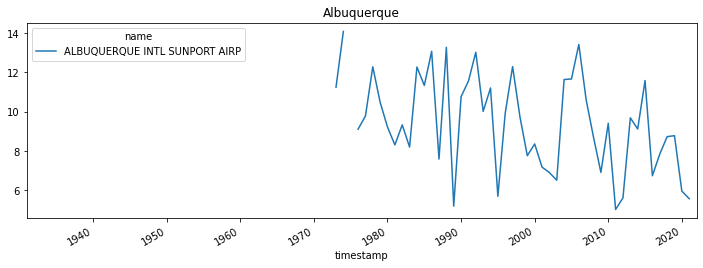

In [157]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Billings'}, xlabel='timestamp'>

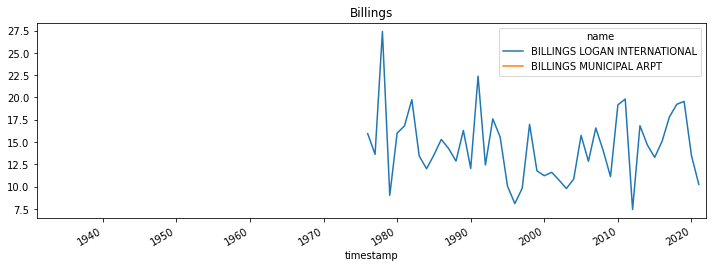

In [158]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Boise'}, xlabel='timestamp'>

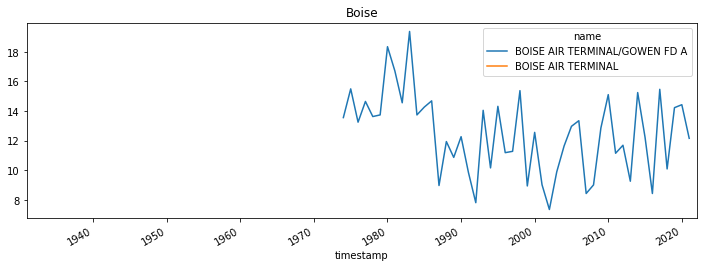

In [159]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Calgary'}, xlabel='timestamp'>

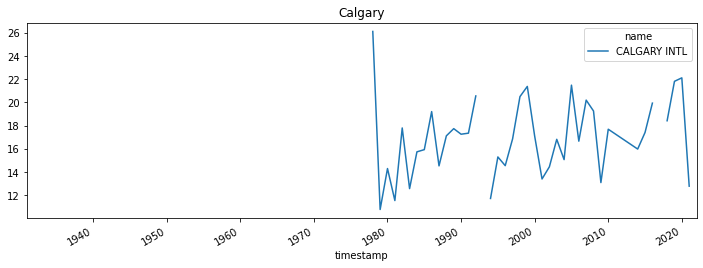

In [160]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Cheyenne'}, xlabel='timestamp'>

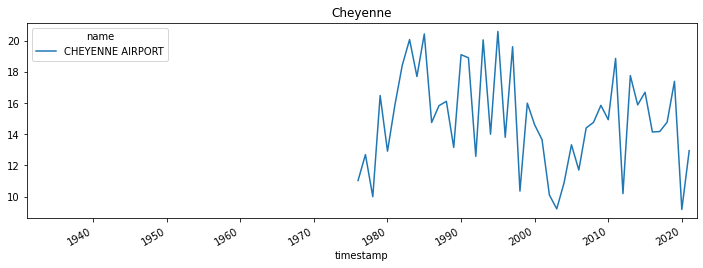

In [161]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Denver'}, xlabel='timestamp'>

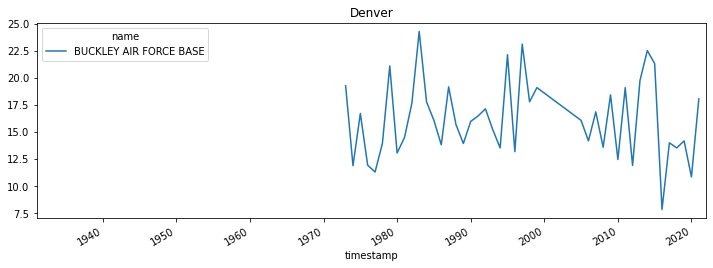

In [162]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Edmonton'}, xlabel='timestamp'>

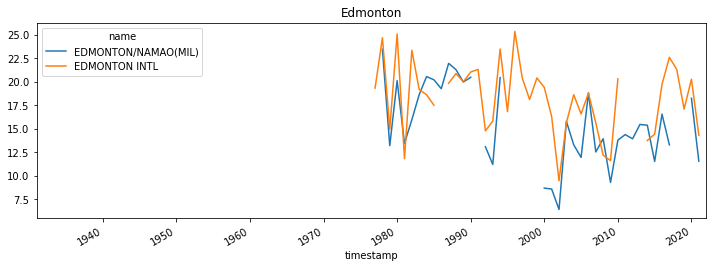

In [163]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Eugene'}, xlabel='timestamp'>

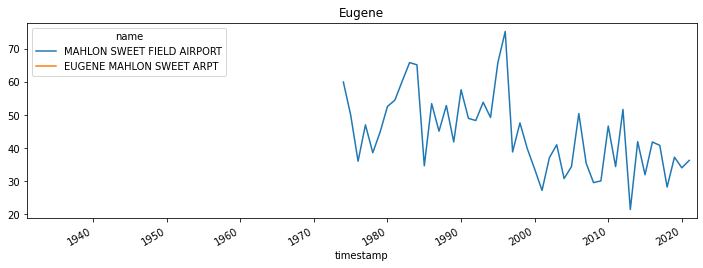

In [164]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Las Vegas'}, xlabel='timestamp'>

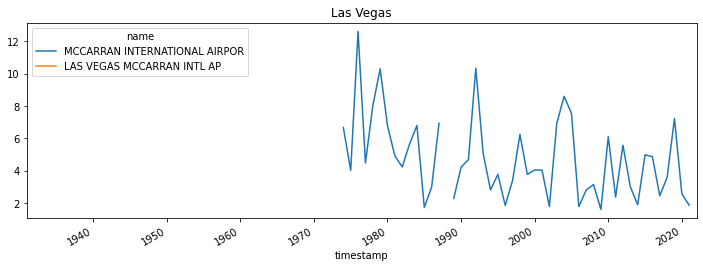

In [165]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Los Angeles'}, xlabel='timestamp'>

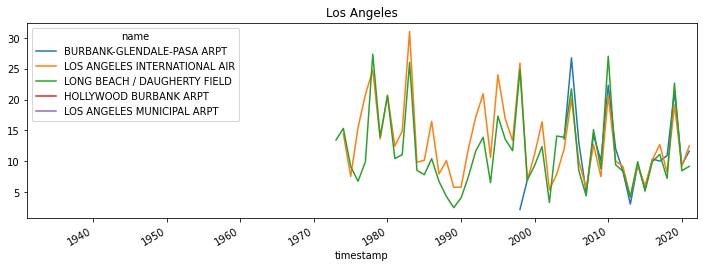

In [166]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Phoenix'}, xlabel='timestamp'>

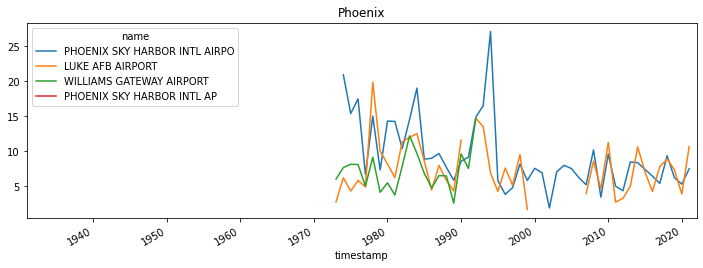

In [167]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Portland'}, xlabel='timestamp'>

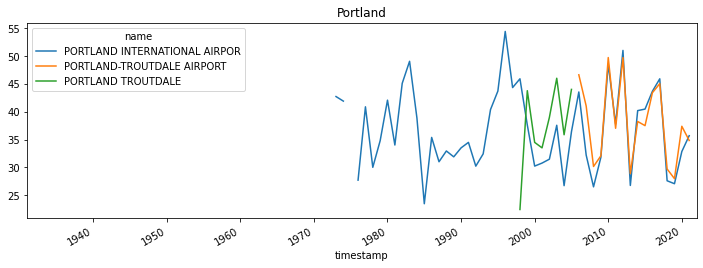

In [168]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Reno'}, xlabel='timestamp'>

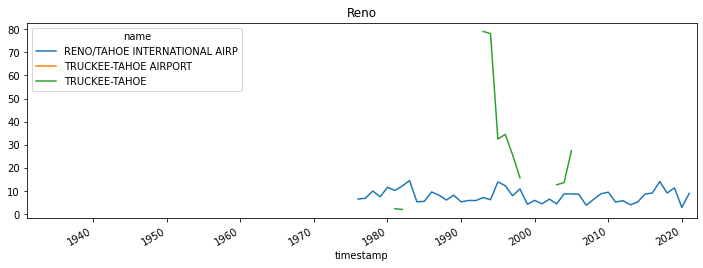

In [169]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Salt Lake City'}, xlabel='timestamp'>

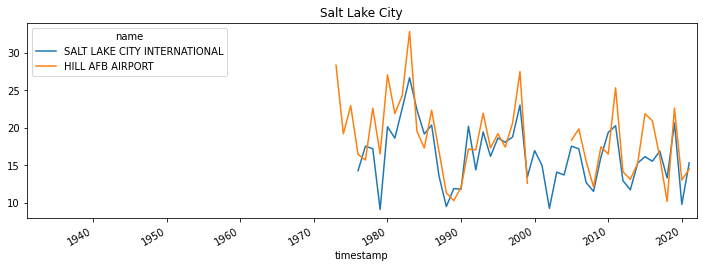

In [170]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'San Diego'}, xlabel='timestamp'>

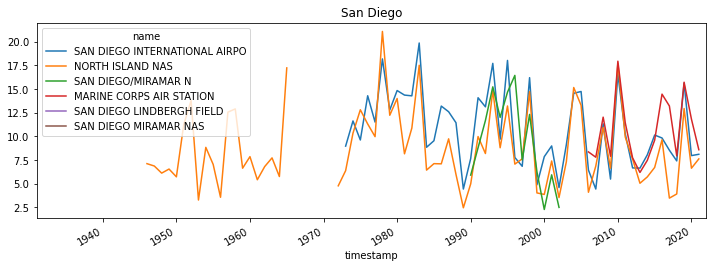

In [171]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'San Francisco'}, xlabel='timestamp'>

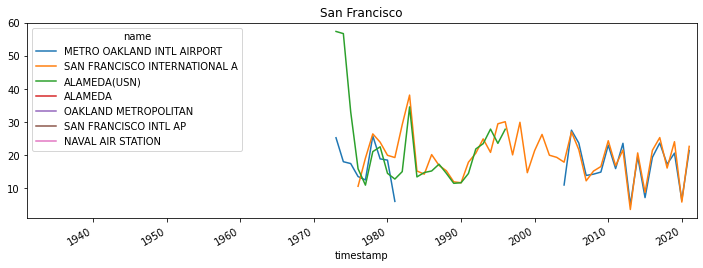

In [172]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Seattle'}, xlabel='timestamp'>

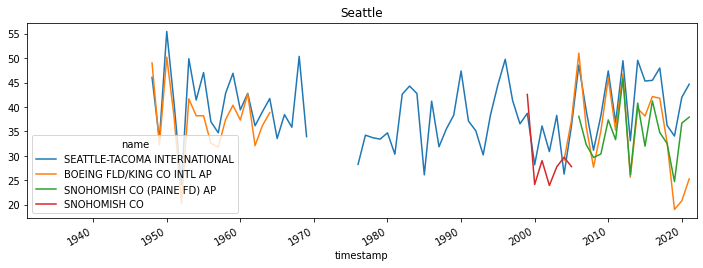

In [173]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Spokane'}, xlabel='timestamp'>

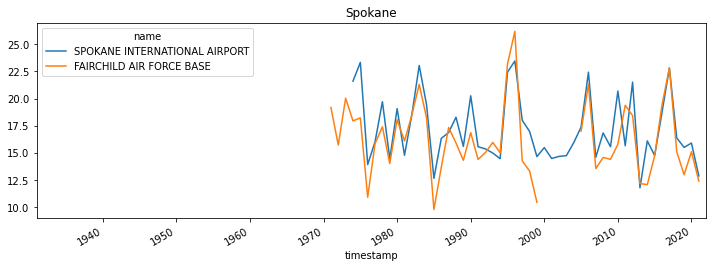

In [174]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Tucson'}, xlabel='timestamp'>

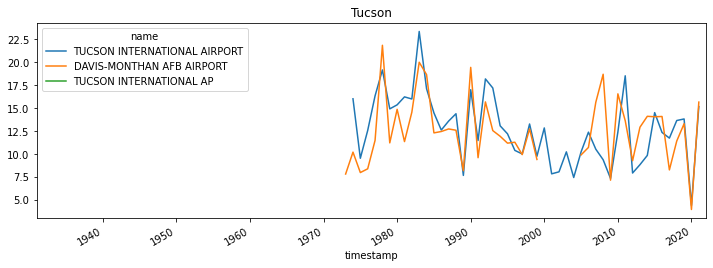

In [175]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

<AxesSubplot:title={'center':'Vancouver'}, xlabel='timestamp'>

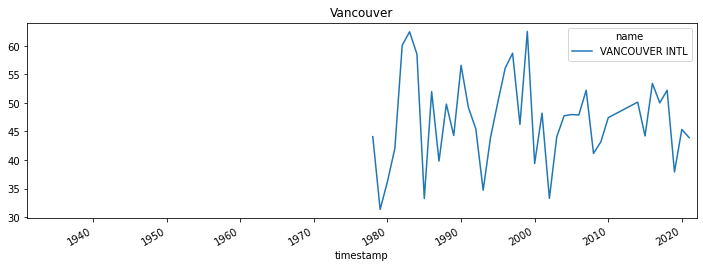

In [176]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

In [177]:
city, precip = next(iter_)
precip = precip.loc[:,'precipitation_total_inches']
precip.unstack(level='name').plot(figsize=(12,4), title=f"{city}", xlim=('1931-01-01', '2022-01-01'))

StopIteration: 